Import Libraries

In [17]:

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sn
from sklearn.decomposition import PCA

Load the preprocessed dataset

In [18]:
# Load the dataset
data = pd.read_csv('bank-additional.csv', delimiter=';')

# Replace "unknown" with NaN
data.replace('unknown', pd.NA, inplace=True)

# Convert yes to 1, no to 0 for the 'y' column
data['y'].replace({'yes': 1, 'no': 0}, inplace=True)

# Identify numeric columns
numeric_columns = data.select_dtypes(include=['number']).columns

# Handle missing values for numeric columns
data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].mean())

# Identify categorical columns
categorical_columns = data.select_dtypes(include=['object']).columns

# Handle missing values for categorical columns
data[categorical_columns] = data[categorical_columns].fillna(data[categorical_columns].mode().iloc[0])

# One-hot encode categorical features using pandas get_dummies
data = pd.get_dummies(data, columns=categorical_columns)

# Convert boolean values to integers (1 for True, 0 for False)
data = data.astype(int)

# Separate input features and prediction feature
X = data.drop(columns=['y'])
y = data['y']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify numeric columns for normalization
numeric_columns = X_train.select_dtypes(include=['number']).columns

# Create a MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on the training data and transform both training and test data
X_train[numeric_columns] = scaler.fit_transform(X_train[numeric_columns])
X_test[numeric_columns] = scaler.transform(X_test[numeric_columns])

Use GridSearch to automate the process of looking for the best parameters

In [26]:
# Create and fit the model
mlr_model = LogisticRegression()

# Define parameter grid for GridSearchCV
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 1, 10, 100],
    'solver': ['lbfgs', 'liblinear', 'saga'],
    'max_iter': [100]
}

# Create GridSearchCV instance
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='accuracy')

# Perform grid search
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Print the best parameters and the corresponding accuracy
print("Best Parameters: ", grid_search.best_params_)
print("Best Accuracy: ", grid_search.best_score_)

/home/joan/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/joan/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/joan/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/joan/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/joan/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/joan/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: Conv

Best Parameters:  {'C': 100, 'max_iter': 100, 'penalty': 'l2', 'solver': 'saga'}
Best Accuracy:  0.9168437025796662


/home/joan/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Use the best parameters for training and calculate the accuracy

In [20]:
# Train the logistic regression model on the entire training set using the best parameters
mlr_model = LogisticRegression(**best_params)
mlr_model.fit(X_train, y_train)

# Predictions on the test set
test_pred = mlr_model.predict(X_test)

# Calculate and print test accuracy
test_accuracy = accuracy_score(y_test, test_pred)
print("Test Accuracy:", test_accuracy)

Test Accuracy: 0.904126213592233


/home/joan/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Compute and plot Confusion Matrices and Error Rate

Error rate: 9.59%


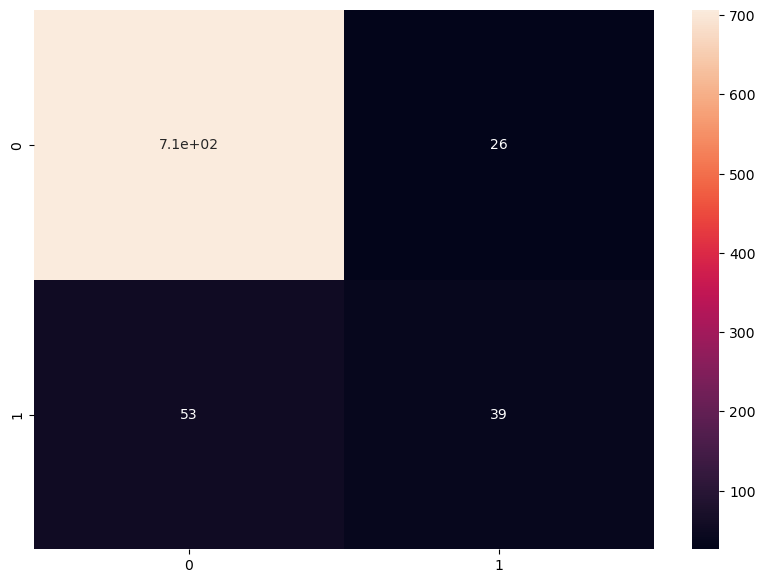

In [21]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, test_pred)

# Compute classification error percentage
error_rate = 100 * (conf_matrix[0, 1] + conf_matrix[1, 0]) / (conf_matrix[0, 0] + conf_matrix[0, 1] + conf_matrix[1, 0] + conf_matrix[1, 1])
print('Error rate: {:.2f}%'.format(error_rate))

# Plot confusion matrix using seaborn heatmap
# Plot the confusion matrix
plt.figure(figsize=(10,7))
sn.heatmap(conf_matrix, annot=True)
plt.show()
plt.show()

Compute and plor ROC

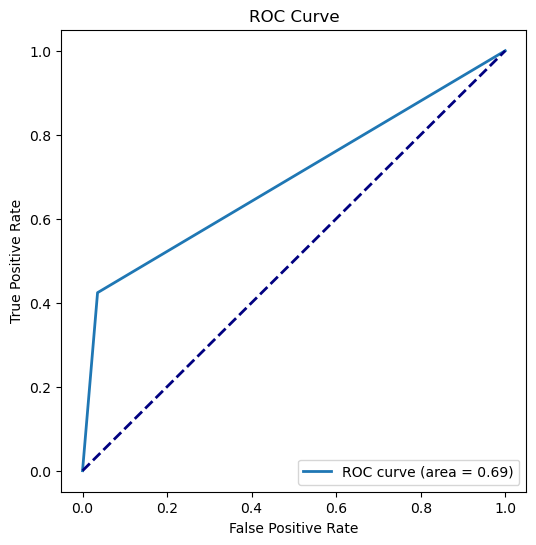

In [22]:
# Compute ROC curve and AUC for Combined Data
fpr, tpr, _ = roc_curve(y_test, test_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

Visualize the data

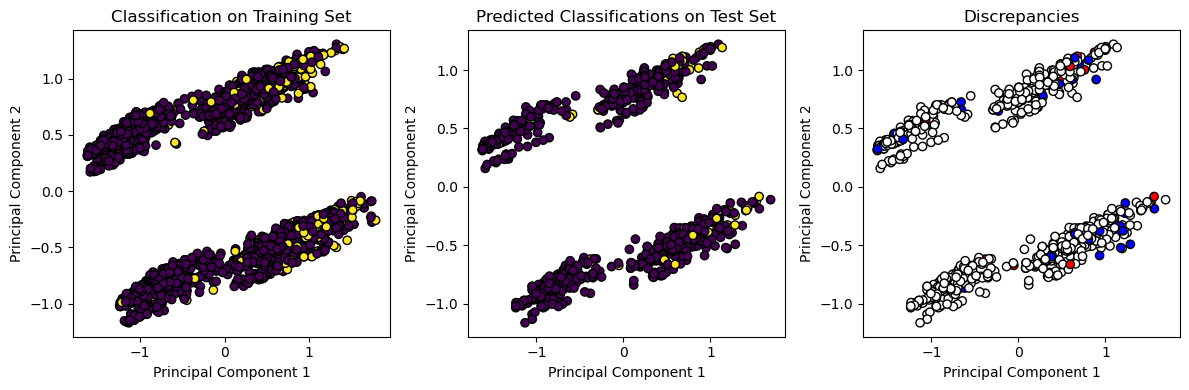

In [25]:
# PCA for dimensionality reduction
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)

# Plot 1: Classification Dynamics on the Training Set
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='viridis', edgecolor='k')
plt.title('Classification on Training Set')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Plot 2: Predicted Classifications on the Test Set
X_test_pca = pca.transform(X_test)
test_pred_pca = pca.transform(X_test)

plt.subplot(1, 3, 2)
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=test_pred, cmap='viridis', edgecolor='k')
plt.title('Predicted Classifications on Test Set')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Plot 3: Discrepancies between Predicted and True Classifications
discrepancies = test_pred - y_test.values
plt.subplot(1, 3, 3)
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=discrepancies, cmap='bwr', edgecolor='k')
plt.title('Discrepancies')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.tight_layout()
plt.show()
